# ECON 148 Project: The Miracle of Microfinance?

## Reproducers: Joey Lee, Colin Flannery, Ronan Muldowney, Jacob McLure, John Belichak

### Preliminary Data Cleaning for Replication

In [1]:
# Load in needed packages
import subprocess
import sys

def install_if_missing(package, import_name=None):
    try:
        if import_name is None:
            import_name = package
        __import__(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install necessary packages
install_if_missing("pandas")
install_if_missing("numpy")
install_if_missing("matplotlib")
install_if_missing("statsmodels")
install_if_missing("linearmodels")
install_if_missing("scipy")

# Now import them (after ensuring installation)
import os
import zipfile
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS, add_constant
from statsmodels.stats.api import anova_lm

from linearmodels.panel import PanelOLS
from scipy.stats import t

# Suppress RuntimeWarnings globally
warnings.filterwarnings("ignore", category=RuntimeWarning)



In [2]:
# Unzip zip file
zip_path = '../Data/113599-V1.zip'
extract_to = './extracted_data'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(os.listdir(extract_to))

['2013-0533_do_figures.do', '2013-0533_data_endlines1and2.dta', '2013-0533_data_census.dta', '2013-0533_data--TO-SUBMIT-', '2013-0533_data_baseline.dta', '2013-0533_do_tables.do', '.ipynb_checkpoints', 'LICENSE.txt', '2013-0533_data_endline1businesstype.dta', 'Readme.pdf']


In [3]:
# Create paths for .dta files
file_path = os.path.join(extract_to, '2013-0533_data_endlines1and2.dta')
file_path_2 = os.path.join(extract_to, '2013-0533_data_baseline.dta')
file_path_3 = os.path.join(extract_to, '2013-0533_data_census.dta')
file_path_4 = os.path.join(extract_to, '2013-0533_data_endline1businesstype.dta')

# Create DataFrames for the different .dta files
endlines = pd.read_stata(file_path)
baseline_main = pd.read_stata(file_path_2)
census = pd.read_stata(file_path_3)

# Table 1A - Baseline Summary Statistics

In [4]:
baseline = baseline_main.copy()

# Group variables by category
hh_composition = ["hh_size", "adults", "children", "male_head", "head_age", "head_noeduc"]
credit_access = ["spandana", "othermfi", "bank", "informal", "anyloan"]
loan_amt = ["spandana_amt", "othermfi_amt", "bank_amt", "informal_amt", "anyloan_amt"]
self_emp_activ = ["total_biz", "female_biz", "female_biz_pct"]
businesses = ["bizrev", "bizexpense", "bizinvestment", "bizemployees", "hours_weekbiz"]

# Create adjusted business variables that apply to all households (0 if no business)
businesses_allHH = []
for var in businesses:
    new_var = f"{var}_allHH"
    businesses_allHH.append(new_var)
    baseline[new_var] = baseline[var]
    baseline.loc[baseline["total_biz"] == 0, new_var] = 0

# Group for consumption-related variables
consumption = ["total_exp_mo", "nondurable_exp_mo", "durables_exp_mo", "home_durable_index"]

# Combine all variable groups into one master list
allvars = hh_composition + credit_access + loan_amt + self_emp_activ + businesses + businesses_allHH + consumption


In [5]:
# Drop NAs
baseline = baseline[baseline['treatment'].notna()]
baseline = baseline.reset_index()

# Convert treatment to binary: 1 = Treatment, 0 = Control
baseline["treatment_binary"] = baseline["treatment"].astype(str).map({"Control": 0, "Treatment": 1})

In [6]:
# Convert selected categorical columns to numeric (1/0), and fill missing values with -1
categorical_cols = ['spandana', 'othermfi', 'bank', 'informal', 'anyloan']

# Convert type, map values, and fill NaNs
for col in categorical_cols:
    baseline[col] = (
        baseline[col]
        .astype('object')
        .replace({'Yes': 1, 'No': 0})
        .fillna(-1)
    )


In [7]:
# Run regressions comparing binary variables between treatment and control groups, clustering by area

# List of variables to include
vars_to_analyze = ['spandana', 'othermfi', 'bank', 'informal', 'anyloan']

# Prepare output list
table1a_binary_results = []

# Ensure binary treatment and areaid category
baseline['treatment_binary'] = baseline['treatment'].map({'Control': 0, 'Treatment': 1}).astype(int)
baseline['areaid'] = baseline['areaid'].astype('category')

for var in vars_to_analyze:
    temp = baseline[[var, 'treatment_binary', 'areaid']].copy()
    temp = temp[temp[var].isin([0, 1])]
    temp = temp.dropna(subset=[var, 'treatment_binary', 'areaid'])

    if temp.empty:
        table1a_results.append([None, None, None, None, None])
        continue

    control = temp[temp['treatment_binary'] == 0]
    N = control.shape[0]
    mean_c = control[var].mean()
    std_c = control[var].std()

    temp['const'] = 1.0
    model = OLS(temp[var], temp[['const', 'treatment_binary']])
    results = model.fit(cov_type='cluster', cov_kwds={'groups': temp['areaid']})

    diff = results.params['treatment_binary']
    p_val = results.pvalues['treatment_binary']

    table1a_binary_results.append([N, mean_c, std_c, diff, p_val])

# Create results DataFrame
table1a_binary_df = pd.DataFrame(table1a_binary_results,
                          columns=["Obs", "Control_mean", "Control_sd", "Difference_in_mean", "P_val"],
                          index=vars_to_analyze)



In [8]:
# allvars = list(baseline.columns)
# Binary vars to exclude from this loop
binary_vars = ['spandana', 'othermfi', 'bank', 'informal', 'anyloan']
non_binary_vars = [var for var in allvars if var not in binary_vars]

# Store regression results here
table1a_nonbinary_results = []

for var in non_binary_vars:
    temp = baseline[[var, 'treatment_binary', 'areaid']].copy()

    # Drop rows with missing values to avoid crash
    temp = temp.dropna()

    # Control group stats
    control = temp[temp['treatment_binary'] == 0]
    N = control.shape[0]
    mean_c = control[var].mean()
    std_c = control[var].std()

    # Default values if regression fails
    diff = np.nan
    p_val = np.nan

    # Check if both treatment and variable have variation
    if temp[var].std() > 0 and temp['treatment_binary'].std() > 0:
        try:
            temp['const'] = 1.0
            model = sm.OLS(temp[var], temp[['const', 'treatment_binary']])
            results = model.fit(cov_type='cluster', cov_kwds={'groups': temp['areaid']})
            diff = results.params['treatment_binary']
            p_val = results.pvalues['treatment_binary']
        except:
            # You can print/log here if needed
            diff = np.nan
            p_val = np.nan
    else:
        # No variation = no regression → set safe defaults
        diff = 0.0
        p_val = 1.0

    table1a_nonbinary_results.append([N, mean_c, std_c, diff, p_val])

# Build final DataFrame
table1a_nonbinary_df = pd.DataFrame(
    table1a_nonbinary_results,
    columns=["Obs", "Control_mean", "Control_sd", "Difference_in_mean", "P_val"],
    index=non_binary_vars
)



In [9]:
# Find index position of 'head_age'
insert_loc = table1a_nonbinary_df.index.get_loc('head_noeduc') + 1

# Split the nonbinary table into two parts: before and after insertion point
top = table1a_nonbinary_df.iloc[:insert_loc]
bottom = table1a_nonbinary_df.iloc[insert_loc:]

table1a_combined_df = pd.concat([top, table1a_binary_df, bottom])


In [10]:
# Round to 3 decimal places
table1a_combined_df = table1a_combined_df.round(3)
table1a_combined_df

,Obs,Control_mean,Control_sd,Difference_in_mean,P_val
hh_size,1220,5.038,1.666,0.095,0.301
adults,1220,3.439,1.466,-0.011,0.873
children,1220,1.599,1.228,0.104,0.095
male_head,1216,0.907,0.290,-0.012,0.379
head_age,1216,41.150,10.839,-0.243,0.675
head_noeduc,1216,0.370,0.483,-0.008,0.786
spandana,1213,0.000,0.000,0.007,0.192
othermfi,1213,0.011,0.103,0.007,0.451
bank,1213,0.036,0.187,0.001,0.858
informal,1213,0.632,0.482,0.002,0.958


# Table 1B -- Endline 1 and 2 Summary Statistics (Control group)

In [11]:
endlines_copy = endlines.copy()

In [12]:
# Create Variable Lists 
hh_composition = ["hhsize", "adults", "children", "male_head", "head_age", "head_noeduc"]
credit_access = ["spandana", "othermfi", "anybank", "anyinformal", "anyloan"]
loan_amt = ["spandana_amt", "othermfi_amt", "bank_amt", "informal_amt", "anyloan_amt"]
self_emp_activ = ["total_biz", "female_biz_allHH", "female_biz_pct"]
businesses = ["bizrev", "bizexpense", "bizinvestment", "bizemployees", "hours_week_biz"]
businesses_allHH = ["bizrev_allHH", "bizexpense_allHH", "bizinvestment_allHH", "bizemployees_allHH", "hours_week_biz_allHH"]
consumption = ["total_exp_mo", "nondurable_exp_mo", "durables_exp_mo", "home_durable_index"]

# Combine all lists into a single list
allvars = (
    hh_composition
    + credit_access
    + loan_amt
    + self_emp_activ
    + businesses
    + businesses_allHH
    + consumption
)


In [13]:
businesses = ["bizrev", "bizexpense", "bizinvestment", "bizemployees", "hours_week_biz"]
additional_vars = ["female_biz"]
vars_to_process = businesses + additional_vars

# Loop through rounds (1 and 2)
for i in [1, 2]:
    for var in vars_to_process:
        var_col = f"{var}_{i}"
        allhh_col = f"{var}_allHH_{i}"
        total_biz_col = f"total_biz_{i}"
        
        # Create the _allHH_ version
        endlines_copy[allhh_col] = endlines_copy[var_col]
        
        # Set value to NaN if household did not run a business
        endlines_copy.loc[endlines_copy[total_biz_col] == 0, var_col] = np.nan


In [14]:
# Rename columns of DataFrame
for var in allvars:
    for suffix in ['1', '2']:
        old_name = f"{var}_{suffix}"
        new_name = f"{var}{suffix}"
        if old_name in endlines_copy.columns:
            endlines_copy.rename(columns={old_name: new_name}, inplace=True)

# Reshape to long format
df_long = pd.wide_to_long(endlines_copy, 
                          stubnames=allvars, 
                          i='hhid', 
                          j='endline', 
                          sep='', 
                          suffix='[12]').reset_index()

In [15]:
df_long = df_long[["hhid", "areaid", "endline", "treatment"] + allvars]

# Create dummy variables for 'endline'
df_long_w_dummies = pd.get_dummies(df_long, columns=["endline"], prefix="endline")

# Split into endline 1 and 2
endline_1 = df_long_w_dummies[df_long_w_dummies["endline_1"] == 1].copy()
endline_2 = df_long_w_dummies[df_long_w_dummies["endline_2"] == 1].copy()

# List of binary categorical columns to convert
binary_cols = ["spandana", "othermfi", "anybank", "anyinformal", "anyloan"]

# Map "Yes"/"No" to 1/0
for col in binary_cols:
    endline_1[col] = endline_1[col].map({"No": 0, "Yes": 1}).astype("float")

# Subset to control group
endline_1_control = endline_1[endline_1["treatment"] == "Control"]

# Generate transposed summary statistics
transpose_1 = (
    endline_1_control.describe()
    .T[["count", "mean", "std"]]
    .reset_index()
)



In [16]:
# Filter for endline 2 data
endline_2 = df_long_w_dummies[df_long_w_dummies["endline_2"] == 1].copy()

# List of binary categorical columns to convert
binary_cols = ["spandana", "othermfi", "anybank", "anyinformal", "anyloan"]

# Map "Yes"/"No" to 1/0 and convert to float
for col in binary_cols:
    endline_2[col] = endline_2[col].map({"No": 0, "Yes": 1}).astype("float")

# Subset to control group
endline_2_control = endline_2[endline_2["treatment"] == "Control"]

# Generate transposed summary statistics
transpose_2 = (
    endline_2_control.describe()
    .T[["count", "mean", "std"]]
    .reset_index()
)



In [17]:

# Combine endline 1 and endline 2 control groups
endline_1_control = endline_1_control.copy()
endline_2_control = endline_2_control.copy()

endline_1_control["endline2"] = 0
endline_2_control["endline2"] = 1

df_ctrl_combined = pd.concat([endline_1_control, endline_2_control])

# List of binary vars you processed earlier
# Container for results
results = []

for var in allvars:
    row = {'index': var}

    # Drop missing values
    df_sub = df_ctrl_combined[["areaid", "endline2", var]].dropna()

    # Summary stats for each endline
    el1_vals = df_sub[df_sub["endline2"] == 0][var]
    el2_vals = df_sub[df_sub["endline2"] == 1][var]

   

    # Run regression with clustered SEs
    try:
        model = smf.ols(f"{var} ~ endline2", data=df_sub).fit(
            cov_type='cluster',
            cov_kwds={'groups': df_sub['areaid']}
        )
        row['Diff'] = model.params['endline2']
        row['P_Value'] = model.pvalues[-1]
    except Exception as e:
        row['Diff'] = np.nan
        row['P_Value'] = np.nan

    results.append(row)

# Create results table
summary_df = pd.DataFrame(results)
summary_df = summary_df[[
    'index', 'Diff', 'P_Value'
]]


In [18]:
# Round 'Diff' and 'P_Value' to 3 decimal places
summary_df[["Diff", "P_Value"]] = summary_df[["Diff", "P_Value"]].round(3)

# Merge endline summaries
summarys = transpose_1.merge(transpose_2, on="index", how="inner")

# Merge with additional summary statistics
full = (
    summarys
    .merge(summary_df, on="index", how="inner")
    .round(3)
    .rename(columns={
        "count_x": "Obs. (1)",
        "mean_x": "Mean (2)",
        "std_x": "SD (3)",
        "count_y": "Obs. (4)",
        "mean_y": "Mean (5)",
        "std_y": "SD (6)",
        "Diff":    "Coeff. (7)"
    })
    .set_index("index")
)

full


,Obs. (1),Mean (2),SD (3),Obs. (4),Mean (5),SD (6),Coeff. (7),P_Value
index,,,,,,,,
hhsize,3264.0,5.645,2.152,2943.0,6.269,2.548,0.624,0.000
adults,3264.0,3.887,1.754,2943.0,4.039,1.848,0.152,0.000
children,3264.0,1.738,1.310,2943.0,1.764,1.321,0.026,0.242
male_head,3261.0,0.895,0.307,2938.0,0.811,0.391,-0.083,0.000
head_age,3257.0,41.149,10.222,2940.0,42.258,10.154,1.109,0.000
head_noeduc,3256.0,0.311,0.463,2940.0,0.292,0.455,-0.020,0.017
spandana,3247.0,0.051,0.219,2943.0,0.111,0.315,0.061,0.000
othermfi,3183.0,0.149,0.356,2943.0,0.268,0.443,0.120,0.000
anybank,3247.0,0.079,0.270,2943.0,0.073,0.260,-0.006,0.476


In [19]:
area_controls = [
    'area_pop_base',
    'area_debt_total_base',
    'area_business_total_base',
    'area_exp_pc_mean_base',
    'area_literate_head_base',
    'area_literate_base'
]

weight_1 = "w1"
weight_2 = "w2"


def weighted_regression_table(variable_list, big_df, weight_list, area_controls = area_controls):
    # Initialize empty list to store results
    results_table = []
    
    for var in variable_list:
        # Subset and drop missing data for current variable and controls
        df_sub = big_df[["treatment", "areaid", weight_list, var] + area_controls].dropna()
    
        if df_sub.empty:
            print(f"Skipping {var} — no valid data")
            continue
    
        # Convert categorical Yes/No to numeric if needed
        if df_sub[var].dtype == "category":
            df_sub[var] = pd.to_numeric(df_sub[var].map({"No": 0, "Yes": 1}))
    
        try:
            # Fit weighted least squares regression with clustering by areaid
            formula = f"{var} ~ treatment + " + " + ".join(area_controls)
            model = smf.wls(formula, data=df_sub, weights=df_sub[weight_list]).fit(
                cov_type='cluster', cov_kwds={'groups': df_sub['areaid']}
            )
        except:
            continue
    
        # Extract regression results
        coef = model.params.get(1, np.nan)           # Treatment coefficient
        se = model.bse.get(1, np.nan)                 # Standard error
        r2 = model.rsquared                           # R-squared
        pval = model.pvalues.get(1, np.nan)           # p-value
    
        # Compute control group statistics
        control_group = df_sub[df_sub["treatment"] == "Control"][var]
        mn1 = control_group.mean()                    # Control group mean
        sd1 = control_group.std()                     # Control group standard deviation
        N = df_sub.shape[0]                           # Number of observations
    
        # Store results
        results_table.append({
            "variable": var,
            "coef": coef,
            "se": se,
            "Observations": N,
            "Control Mean": mn1,
            "pval": pval
        })
    
    # Convert results to DataFrame and round values
    results_table = round(pd.DataFrame(results_table), 3)
    
    return results_table


# Table 2 -- Credit

In [20]:
endlines_copy_2 = endlines.copy()

In [21]:
variables_table2_el1 = [
    'spandana_1', 'othermfi_1', 'anymfi_1', 'anybank_1', 'anyinformal_1', 'anyloan_1',
    'everlate_1', 'mfi_loan_cycles_1', 'spandana_amt_1', 'othermfi_amt_1', 'anymfi_amt_1',
    'bank_amt_1', 'informal_amt_1', 'anyloan_amt_1', 'credit_index_1'
]

table_2_endline_1 = weighted_regression_table(variables_table2_el1, endlines_copy_2, weight_1, area_controls = area_controls)

table_2_endline_1.set_index("variable").T

variable,spandana_1,othermfi_1,anymfi_1,anybank_1,anyinformal_1,anyloan_1,everlate_1,mfi_loan_cycles_1,spandana_amt_1,othermfi_amt_1,anymfi_amt_1,bank_amt_1,informal_amt_1,anyloan_amt_1,credit_index_1
coef,0.127,-0.012,0.083,0.003,-0.052,-0.022,-0.060,0.084,1333.772,-93.668,1285.694,74.957,-1068.984,2856.236,0.106
se,0.020,0.024,0.027,0.012,0.021,0.014,0.026,0.041,229.681,336.298,439.433,2163.016,2519.661,4548.265,0.029
Observations,6811.000,6657.000,6811.000,6811.000,6811.000,6862.000,6475.000,6816.000,6811.000,6708.000,6811.000,6811.000,6811.000,6862.000,6862.000
Control Mean,0.051,0.149,0.183,0.079,0.761,0.867,0.616,0.330,597.441,1806.026,2373.776,8422.431,41044.621,59836.265,0.000
pval,0.000,0.626,0.002,0.811,0.015,0.102,0.024,0.041,0.000,0.781,0.003,0.972,0.671,0.530,0.000


In [22]:
variables_table2_el2 = [
    'spandana_2', 'othermfi_2', 'anymfi_2', 'anybank_2', 'anyinformal_2', 'anyloan_2',
    'everlate_2', 'mfi_loan_cycles_2', 'spandana_amt_2', 'othermfi_amt_2', 'anymfi_amt_2',
    'bank_amt_2', 'informal_amt_2', 'anyloan_amt_2', 'credit_index_2'
]

table_2_endline_2 = weighted_regression_table(variables_table2_el2, endlines_copy_2, weight_2, area_controls = area_controls)
table_2_endline_2.set_index("variable").T

variable,spandana_2,othermfi_2,anymfi_2,anybank_2,anyinformal_2,anyloan_2,everlate_2,mfi_loan_cycles_2,spandana_amt_2,othermfi_amt_2,anymfi_amt_2,bank_amt_2,informal_amt_2,anyloan_amt_2,credit_index_2
coef,0.063,-0.039,0.002,0.001,0.002,0.000,0.007,0.085,979.412,-217.103,798.570,-1180.783,158.294,2554.018,0.029
se,0.018,0.026,0.029,0.009,0.018,0.010,0.021,0.067,286.586,627.579,669.015,1085.622,2939.685,6155.602,0.025
Observations,6142.000,6142.000,6142.000,6142.000,6142.000,6142.000,6142.000,5926.000,6142.000,6142.000,6142.000,6142.000,6142.000,6142.000,6142.000
Control Mean,0.111,0.268,0.331,0.073,0.603,0.904,0.598,0.724,1566.640,4775.060,5544.164,6126.523,32355.986,88631.460,-0.000
pval,0.001,0.139,0.941,0.930,0.903,0.983,0.740,0.204,0.001,0.729,0.233,0.277,0.957,0.678,0.254


# Table 3 -- Self-Employment Activities: Revenues, Assets, and Profits

In [23]:
variables_3A_1 = [
    'bizassets_1', 'bizinvestment_1', 'bizexpense_1', 'bizprofit_1',
    'any_biz_1', 'total_biz_1', 'any_new_biz_1', 'biz_stop_1', 'biz_index_all_1'
]

table_3_E1 = weighted_regression_table(variables_3A_1, endlines_copy_2, weight_1, area_controls = area_controls)
table_3_E1.set_index("variable").T

variable,bizassets_1,bizinvestment_1,bizexpense_1,bizprofit_1,any_biz_1,total_biz_1,any_new_biz_1,biz_stop_1,biz_index_all_1
coef,597.510,390.853,254.664,354.338,0.008,0.018,0.009,0.002,0.036
se,383.518,212.695,1056.330,313.531,0.021,0.038,0.006,0.008,0.019
Observations,6800.000,6800.000,6685.000,6239.000,6810.000,6810.000,6757.000,2352.000,6810.000
Control Mean,2497.549,280.069,4055.445,744.898,0.349,0.503,0.047,0.037,0.000
pval,0.119,0.066,0.809,0.258,0.699,0.636,0.142,0.801,0.056


In [24]:
variables_3A_2 =  ['bizassets_2', 'bizinvestment_2', 'bizexpense_2', 
             'bizprofit_2', 'any_biz_2', 'total_biz_2', 
             'any_new_biz_2', 'biz_stop_2', 'biz_index_all_2']

table_3_E2 = weighted_regression_table(variables_3A_2, endlines_copy_2, weight_2, area_controls = area_controls)
table_3_E2.set_index("variable").T

variable,bizassets_2,bizinvestment_2,bizexpense_2,bizprofit_2,any_biz_2,total_biz_2,any_new_biz_2,biz_index_all_2
coef,1260.792,-133.688,-530.422,541.995,0.023,0.045,-0.000,0.015
se,529.814,206.581,546.714,371.709,0.023,0.040,0.010,0.019
Observations,6142.000,6142.000,6116.000,6090.000,6142.000,6142.000,6142.000,6142.000
Control Mean,5002.792,1007.315,5224.676,953.132,0.418,0.561,0.083,0.000
pval,0.017,0.518,0.332,0.145,0.332,0.261,0.988,0.419


# Table 3B -- Self-Employment Activities: Revenues, Assets, and Profits 
### (Households with old businesses)

In [25]:
business_variables_1 = ["bizassets_1", "bizinvestment_1", "bizrev_1", "bizexpense_1", 
                      "bizprofit_1", "bizemployees_1", "biz_index_old_1"]

endlines_copy_2["any_old_biz"] = endlines_copy_2["any_old_biz"].map({"No": 0, "Yes": 1})
endlines_copy_old_biz_1 = endlines_copy_2[endlines_copy_2["any_old_biz"] == 1]


table_3B_endline_1 = weighted_regression_table(business_variables_1, endlines_copy_old_biz_1, weight_1, area_controls = area_controls)
table_3B_endline_1

,variable,coef,se,Observations,Control Mean,pval
0,bizassets_1,897.632,1062.772,2083,6757.323,0.398
1,bizinvestment_1,1119.416,698.071,2083,677.894,0.109
2,bizrev_1,5266.227,3720.661,1955,14504.637,0.157
3,bizexpense_1,1640.230,3256.508,2020,12325.417,0.614
4,bizprofit_1,2105.439,1099.960,1624,2037.855,0.056
5,bizemployees_1,-0.053,0.082,2088,0.413,0.520
6,biz_index_old_1,0.090,0.041,2088,-0.000,0.026


In [26]:
business_variables_2 = ["bizassets_2", "bizinvestment_2", "bizrev_2", "bizexpense_2", 
                      "bizprofit_2", "bizemployees_2", "biz_index_old_2"]


table_3B_endline_2 = weighted_regression_table(business_variables_2, endlines_copy_old_biz_1, weight_2, area_controls = area_controls)
table_3B_endline_2.set_index("variable").T

variable,bizassets_2,bizinvestment_2,bizrev_2,bizexpense_2,bizprofit_2,bizemployees_2,biz_index_old_2
coef,1682.026,-948.624,343.309,-2644.306,839.203,-0.124,-0.007
se,1412.432,587.964,1262.962,1491.004,944.994,0.100,0.026
Observations,1878.000,1878.000,1859.000,1862.000,1844.000,1878.000,1878.000
Control Mean,10301.054,2292.123,12563.964,12418.353,1948.239,0.462,0.000
pval,0.234,0.107,0.786,0.076,0.375,0.215,0.790


# Table 3C -- Self-Employment Activities: Revenues, Assets, and Profits
### (Households with new businesses, EL1 only)

In [27]:
business_variables_new_1 = ["bizassets_1", "bizinvestment_1", "bizrev_1", "bizexpense_1", 
                      "bizprofit_1", "bizemployees_1", "biz_index_new_1"]


new_biz_no_na = endlines_copy_2.dropna(subset = ["newbiz_1"])
new_business_1 = new_biz_no_na[new_biz_no_na["newbiz_1"] > 0]


table_3C = weighted_regression_table(business_variables_new_1, new_business_1, weight_1, area_controls = area_controls)
table_3C.set_index("variable").T


variable,bizassets_1,bizinvestment_1,bizrev_1,bizexpense_1,bizprofit_1,bizemployees_1,biz_index_new_1
coef,-872.616,-705.549,-8166.723,-5012.906,-3547.546,-0.195,-0.081
se,2200.692,1324.094,7313.812,4048.930,3813.119,0.112,0.044
Observations,356.000,356.000,332.000,339.000,270.000,356.000,356.000
Control Mean,8410.855,2418.092,17423.027,12114.004,6081.094,0.289,0.000
pval,0.692,0.594,0.264,0.216,0.352,0.083,0.067


# Figures

#

In [28]:
# Assume endlines_1_2 is already loaded as a pandas DataFrame
endlines_1_2_f2 = endlines.copy()

# Drop rows with missing key variables
endlines_1_2_f2 = endlines_1_2_f2.dropna(subset=['any_old_biz', 'any_biz_1', 'any_biz_2'])

# Map "Yes"/"No" to binary values, allowing NaN to remain
binary_mapping = {'Yes': 1, 'No': 0}
for col in ['any_old_biz', 'any_biz_1', 'any_biz_2']:
    endlines_1_2_f2[col] = endlines_1_2_f2[col].map(binary_mapping)

# Assign business profit variables based on old/new biz logic
endlines_1_2_f2 = endlines_1_2_f2.assign(
    bizprofit_1_old=endlines_1_2_f2['bizprofit_1'].where(endlines_1_2_f2['any_old_biz'] == 1),
    bizprofit_1_new=endlines_1_2_f2['bizprofit_1'].where(endlines_1_2_f2['any_old_biz'] == 0),
    bizprofit_1_biz=endlines_1_2_f2['bizprofit_1'].where(endlines_1_2_f2['any_biz_1'] == 1),
    bizprofit_2_biz=endlines_1_2_f2['bizprofit_2'].where(endlines_1_2_f2['any_biz_2'] == 1)
)


# Set random seed for reproducibility
np.random.seed(65209844)

# Run quantile and OLS regressions
results = {}
variables = ['informal_amt_1', 'bizprofit_1_old', 'bizprofit_1_new', 'bizprofit_2_biz']
quantiles = np.arange(0.05, 0.98, 0.02)

for var in variables:
    var_results = []
    for q in quantiles:
        try:
            df_reg = endlines_1_2_f2[[var, 'treatment', 'areaid']].dropna()

            # Ensure treatment is treated as categorical (optional: if 0/1, leave as is)
            if df_reg['treatment'].dtype != 'category':
                df_reg['treatment'] = df_reg['treatment'].astype('category')

            ols_model = smf.ols(f'{var} ~ treatment', data=df_reg).fit(
                cov_type='cluster', cov_kwds={'groups': df_reg['areaid']}
            )

            # Determine correct parameter name for treatment
            ols_param = [k for k in ols_model.params.keys() if 'treatment' in k.lower()]
            betaols = ols_model.params[ols_param[0]] if ols_param else np.nan

            if not df_reg.empty:
                qreg_model = smf.quantreg(f'{var} ~ treatment', data=df_reg).fit(q=q, max_iter=2000)
                qreg_param = [k for k in qreg_model.params.keys() if 'treatment' in k.lower()]
                beta = qreg_model.params[qreg_param[0]] if qreg_param else np.nan
                se = qreg_model.bse[qreg_param[0]] if qreg_param else np.nan

                # Confidence intervals using t-distribution
                alpha = 0.1
                df_resid = qreg_model.df_resid
                ts = t.ppf(1 - alpha / 2, df_resid)
                cil = beta - (ts * se)
                ciu = beta + (ts * se)

                var_results.append([q, betaols, beta, cil, ciu])
            else:
                var_results.append([q, np.nan, np.nan, np.nan, np.nan])

        except Exception as e:
            var_results.append([q, np.nan, np.nan, np.nan, np.nan])

    results[var] = pd.DataFrame(var_results, columns=['qtile', 'ols_treatment', 'treatment', 'treatment_cilo', 'treatment_cihi'])


# Figure 2. Treatment Effect on Informal Borrowing (Endline 1)

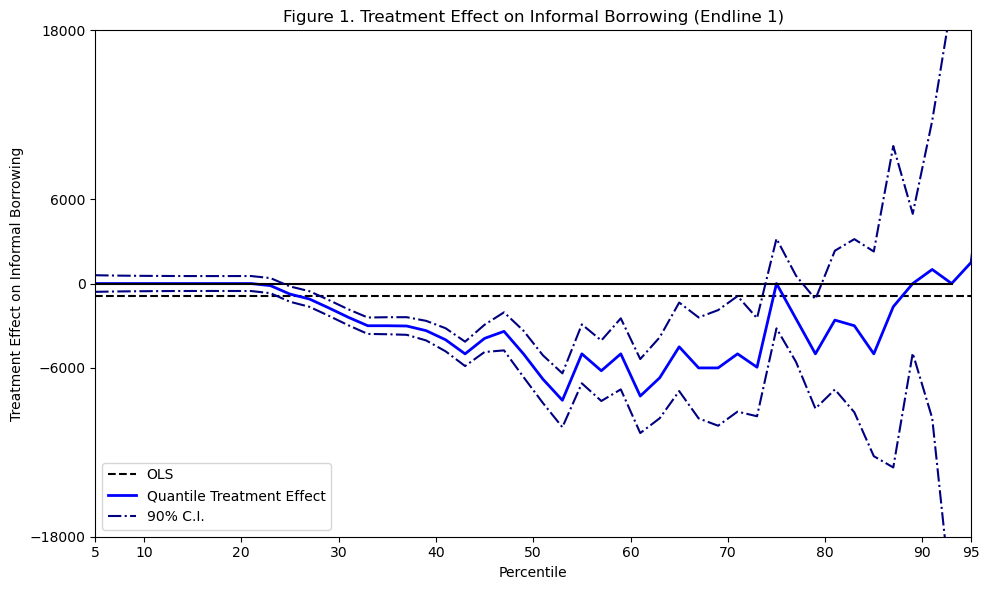

In [29]:
# Prepare data for plotting Figure 1 (informal_amt_1)
df_plot = results['informal_amt_1'].copy()
df_plot['Percentile'] = df_plot['qtile'] * 100
df_plot['y0'] = 0
df_plot.loc[(df_plot['Percentile'] < 5) | (df_plot['Percentile'] > 95), 'y0'] = None

# Truncate extreme CI values
df_plot.loc[df_plot['treatment_cihi'] > 20000, 'treatment_cihi'] = 20000
df_plot.loc[df_plot['Percentile'] == 95, 'treatment_cihi'] = None

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_plot['Percentile'], df_plot['ols_treatment'], linestyle='--', label='OLS', color='black')
plt.plot(df_plot['Percentile'], df_plot['treatment'], linewidth=2, color='blue', label='Quantile Treatment Effect')
plt.plot(df_plot['Percentile'], df_plot['y0'], color='black')
plt.plot(df_plot['Percentile'], df_plot['treatment_cihi'], linestyle='-.', color='navy', label='90% C.I.')
plt.plot(df_plot['Percentile'], df_plot['treatment_cilo'], linestyle='-.', color='navy')
plt.fill_between(df_plot['Percentile'], df_plot['treatment_cilo'], df_plot['treatment_cihi'], color='white', alpha=1.0)

# Final touches
plt.xlabel('Percentile')
plt.ylabel('Treatment Effect on Informal Borrowing')
plt.title('Figure 1. Treatment Effect on Informal Borrowing (Endline 1)')
plt.xticks([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95])
plt.yticks([-18000, -6000, 0, 6000, 18000])
plt.xlim(5, 95)
plt.ylim(-18000, 18000)
plt.legend(loc='lower left', frameon=True)
plt.grid(False)
plt.tight_layout()

plt.show();

# Figure 3. Treatment Effect on Business Profits
## (HHs who have an old business, endline 1)

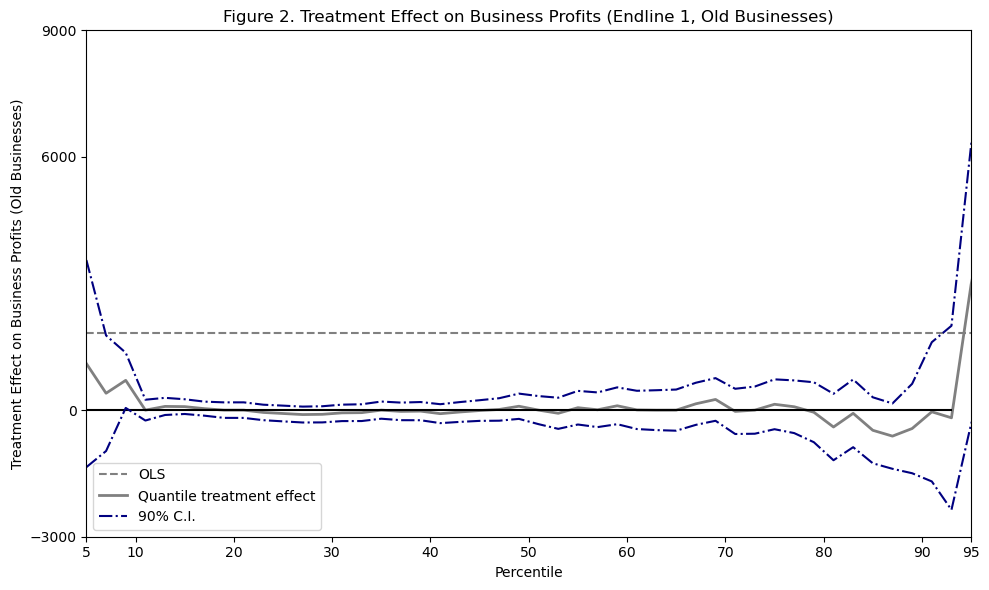

In [30]:
# Assuming you already have the data loaded in `endlines_1_2_f2_copy`

df_plot2 = results['bizprofit_1_old'].copy()  # use bizprofit_1_old
df_plot2['Percentile'] = df_plot2['qtile'] * 100
df_plot2['y0'] = 0
df_plot2.loc[(df_plot2['Percentile'] < 5) | (df_plot2['Percentile'] > 95), 'y0'] = None

# Truncate confidence intervals for better visualization
df_plot2.loc[df_plot2['treatment_cihi'] > 20000, 'treatment_cihi'] = 20000
df_plot2.loc[df_plot2['Percentile'] == 95, 'treatment_cihi'] = None

# Create the plot for Figure 2
plt.figure(figsize=(10, 6))
plt.plot(df_plot2['Percentile'], df_plot2['ols_treatment'], linestyle='--', label='OLS', color='gray')
plt.plot(df_plot2['Percentile'], df_plot2['treatment'], linewidth=2, color='gray', label='Quantile treatment effect')
plt.plot(df_plot2['Percentile'], df_plot2['y0'], color='black')
plt.plot(df_plot2['Percentile'], df_plot2['treatment_cihi'], linestyle='-.', color='navy', label='90% C.I.')
plt.plot(df_plot2['Percentile'], df_plot2['treatment_cilo'], linestyle='-.', color='navy')
plt.fill_between(df_plot2['Percentile'], df_plot2['treatment_cilo'], df_plot2['treatment_cihi'], color='white', alpha=1.0)

# Labels and Title
plt.xlabel('Percentile')
plt.ylabel('Treatment Effect on Business Profits (Old Businesses)')
plt.title('Figure 2. Treatment Effect on Business Profits (Endline 1, Old Businesses)')
plt.xticks([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95])
plt.yticks([-3000, -6000, 0, 6000, 9000])
plt.xlim(5, 95)
plt.ylim(-3000, 9000)  # Adjust y-axis limits based on data
plt.legend(loc='lower left', frameon=True)
plt.grid(False)
plt.tight_layout()

plt.show()